In [2]:
from pharynx_redox import (
    pharynx_io as pio, 
    image_processing as ip, 
    experiment, 
    plots, 
    profile_processing,
    data_analysis as da
)

import xarray as xr
from pathlib import Path
from tqdm import tqdm_notebook
from scipy import signal
import seaborn as sns
from importlib import reload
import numpy as np
import logging
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

reload(logging)
reload(experiment)
reload(pio)
reload(ip)
reload(plots)
reload(profile_processing)
reload(da)

# pd.set_option('display.height', 500)
pd.set_option('display.max_rows', 100)

logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s', level=logging.DEBUG, datefmt='%I:%M:%S')

In [3]:
params = dict(
    experiment_dir=Path("/Users/sean/code/pharynx_redox/data/paired_ratio/2017_02_22-HD233_SAY47/"),
    imaging_scheme="TL/470/410/470/410",
    register=False
)

ex_unreg = experiment.PairExperiment(**params).full_pipeline()
# ex_reg = experiment.PairExperiment(**params, should_register=True).full_pipeline()

01:12:22 INFO:Starting full pipeline run for /Users/sean/code/pharynx_redox/data/paired_ratio/2017_02_22-HD233_SAY47
01:12:22 INFO:Segmenting pharynxes
01:12:24 INFO:Centering and rotating pharynxes


01:12:33 INFO:Calculating midlines


01:12:34 INFO:Measuring under midlines


01:12:35 INFO:Trimming intensity data


01:12:36 INFO:Calculating redox measurements
/Users/sean/.local/share/virtualenvs/worm/lib/python3.7/site-packages/xarray/core/computation.py:564: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)
01:12:36 INFO:Saving 2017_02_22-HD233_SAY47 inside /Users/sean/code/pharynx_redox/data/paired_ratio/2017_02_22-HD233_SAY47
01:12:36 INFO:Saving region means to /Users/sean/code/pharynx_redox/data/paired_ratio/2017_02_22-HD233_SAY47/analyses/2019-09-26_frame_specific_midlines_with_registration/2017_02_22-HD233_SAY47-summary_table.csv
01:12:37 INFO:Saving untrimmed profile data to /Users/sean/code/pharynx_redox/data/paired_ratio/2017_02_22-HD233_SAY47/analyses/2019-09-26_frame_specific_midlines_with_registration/2017_02_22-HD233_SAY47-untrimmed_profile_data.nc
01:12:37 INFO:Saving trimmed profile data to /Users/sean/code/pharynx_redox/data/paired_ratio/2017_02_22-HD233_SAY47/analyses/2019-09-26_frame_specific_midlines_with_registration/2017_02_22-HD233_SAY47-tri

In [6]:
idx = 90
stationary_pair = 1
moving_pair = 0

# stationary
i410_stationary = ex_unreg.untrimmed_profiles.sel(wavelength='410', pair=stationary_pair)[idx]
i470_stationary = ex_unreg.untrimmed_profiles.sel(wavelength='470', pair=stationary_pair)[idx]
s410_stationary = profile_processing.smooth_profile_data(i410_stationary, smoothing_parameter=1e-6)
s470_stationary = profile_processing.smooth_profile_data(i470_stationary, smoothing_parameter=1e-6)

# moving
i410_moving = ex_unreg.untrimmed_profiles.sel(wavelength='410', pair=moving_pair)[idx]
i470_moving = ex_unreg.untrimmed_profiles.sel(wavelength='470', pair=moving_pair)[idx]
s410_moving = profile_processing.smooth_profile_data(i410_moving, smoothing_parameter=1e-6)
s470_moving = profile_processing.smooth_profile_data(i470_moving, smoothing_parameter=1e-6)

In [17]:
list(ex_unreg.trimmed_regions.keys())

['pm3', 'pm4', 'pm5', 'pm6', 'pm7']

01:16:35 WARNING:No handles with labels found to put in legend.
/Users/sean/.local/share/virtualenvs/worm/lib/python3.7/site-packages/ipykernel_launcher.py:103: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


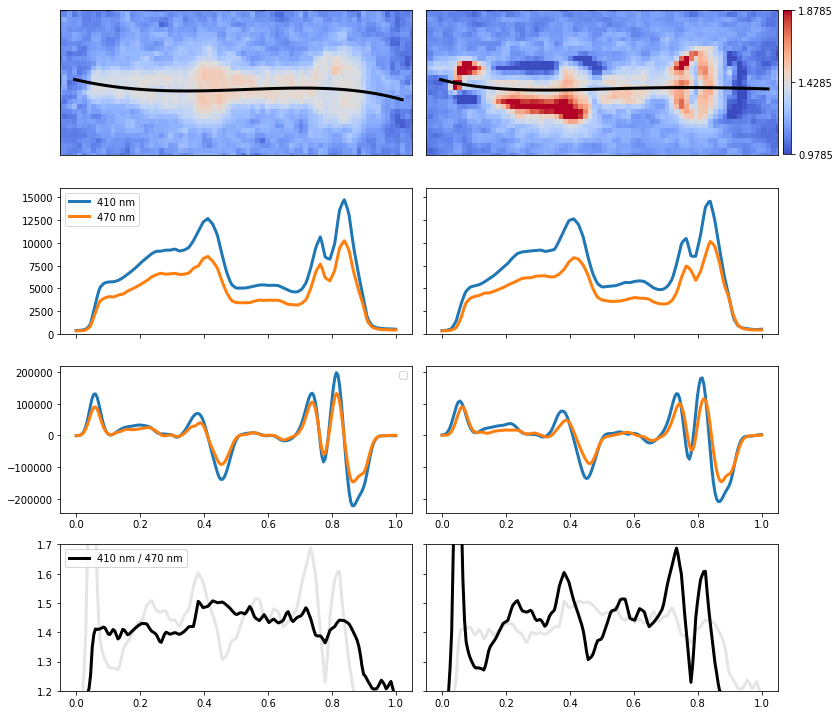

In [13]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

font = {'size'   : 10}

matplotlib.rc('font', **font)
matplotlib.rc('text', usetex=False)

fig, axes = plt.subplots(4,2, sharey='row', figsize=(11, 10))


midline_color = 'black'
midline_width = 3
profile_linewidth = 3

r_center = np.mean(
    (ex_unreg.trimmed_profiles.sel(wavelength='410', pair=stationary_pair)[idx] /
    ex_unreg.trimmed_profiles.sel(wavelength='470', pair=stationary_pair)[idx])
)
r_range = 0.45

ax= axes[0, 1]
im = ax.imshow(
    (ex_unreg.rot_fl.sel(wavelength='410', pair=moving_pair)[idx] /
    ex_unreg.rot_fl.sel(wavelength='470', pair=moving_pair)[idx]),
    aspect='equal',
    clim=(1,1.6),
    cmap='coolwarm',
    vmin=r_center-r_range,
    vmax=r_center+r_range,
)
# COLORBAR
ax_bbox = ax.get_position()
pad = 0.17
cbar_w = .01
cax = fig.add_axes([ax_bbox.xmax+pad, ax_bbox.ymin+.068, cbar_w, .2])
cax.yaxis.set_ticks_position('right')
cbar = plt.colorbar(im, cax=cax, ticks=[r_center-r_range, r_center, r_center+r_range])

ax.plot(*ex_unreg.midlines[idx]['410'][stationary_pair].linspace(), color=midline_color, linewidth=midline_width)
ax.set_xlim(47, 120)
ax.set_ylim(50, 80)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

ax = axes[0,0]
im = ax.imshow(
    (ex_unreg.rot_fl.sel(wavelength='410', pair=stationary_pair)[idx] /
    ex_unreg.rot_fl.sel(wavelength='470', pair=stationary_pair)[idx]),
    aspect='equal',
    clim=(1,1.6),
    cmap='coolwarm',
    vmin=r_center-r_range,
    vmax=r_center+r_range,
)
ax.plot(*ex_unreg.midlines[idx]['410'][moving_pair].linspace(), color=midline_color, linewidth=midline_width)
ax.set_xlim(47, 120)
ax.set_ylim(50, 80)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

# INTENSITY
xs = np.linspace(0, 1, 200)
# vline_xs = [0.41, 0.764, 0.84]
# for x in vline_xs:
#     axes[1,0].axvline(x, color='lightgray')

axes[1,0].plot(xs, ex_unreg.untrimmed_profiles.sel(wavelength='410', pair=stationary_pair)[idx], label='410 nm', linewidth=profile_linewidth)
axes[1,0].plot(xs, ex_unreg.untrimmed_profiles.sel(wavelength='470', pair=stationary_pair)[idx], label='470 nm', linewidth=profile_linewidth)

# vline_xs = [0.41, 0.764, 0.84]
# for x in vline_xs:
#     axes[1,1].axvline(x, color='lightgray')
axes[1,1].plot(xs, ex_unreg.untrimmed_profiles.sel(wavelength='410', pair=moving_pair)[idx], linewidth=profile_linewidth)
axes[1,1].plot(xs, ex_unreg.untrimmed_profiles.sel(wavelength='470', pair=moving_pair)[idx], linewidth=profile_linewidth)
axes[1,0].legend(loc='upper left')

plt.setp(axes[1,0].get_xticklabels(), visible=False)
plt.setp(axes[1,1].get_xticklabels(), visible=False)
axes[1,0].set_ylim(0, 16000)
axes[1,1].set_ylim(0, 16000)

# DERIVATIVES
# stationary
xs = np.linspace(0, 1, 200)
axes[2,0].plot(xs, np.squeeze(s410_stationary[0].derivative()(xs)), linewidth=profile_linewidth)
axes[2,0].plot(xs, np.squeeze(s470_stationary[0].derivative()(xs)), linewidth=profile_linewidth)
axes[2,0].legend()

# moving
xs = np.linspace(0, 1, 200)
axes[2,1].plot(xs, np.squeeze(s410_moving[0].derivative()(xs)), linewidth=profile_linewidth)
axes[2,1].plot(xs, np.squeeze(s470_moving[0].derivative()(xs)), linewidth=profile_linewidth)

# RATIOS
xs = np.linspace(0, 1, 200)
axes[3,0].plot(xs, ex_unreg.untrimmed_profiles.sel(wavelength='r', pair=stationary_pair)[idx], color='k', label='410 nm / 470 nm', linewidth=profile_linewidth)
axes[3,0].plot(xs, ex_unreg.untrimmed_profiles.sel(wavelength='r', pair=moving_pair)[idx], color='k', alpha=0.1, linewidth=profile_linewidth)
axes[3,0].legend(loc='upper left')
axes[3,1].plot(xs, ex_unreg.untrimmed_profiles.sel(wavelength='r', pair=moving_pair)[idx], color='k', linewidth=profile_linewidth)
axes[3,1].plot(xs, ex_unreg.untrimmed_profiles.sel(wavelength='r', pair=stationary_pair)[idx], color='k', alpha=0.1, linewidth=profile_linewidth)
axes[3,1].set_ylim(1.2,1.7)

plt.tight_layout()
# plt.savefig('~/Desktop/testing.pdf')